# generic scikit-learn classifier

run any scikit-learn compatible classifier or list of classifiers

## steps
1. **generate a scikit-learn model configuration** using the `model_pkg_class` parameter
   * input a package and class name, for example, `sklearn.linear_model.LogisticRegression`  
   * mlrun will find the class and instantiate a copy using default parameters  
   * You can modify both the model class instantiator and the fit methods  (other functions could be similarly modified)
2. **get a sample of data** from a data source
   * select all rows using -1
   * select a random sample of rows using a negative integer
   * select consecutive rows using a positive integer
3. **split the data** into train, validation, and test sets 
   * the test set is saved as an artifact and never seen again until testing
   * WIP: this will be parametrized to produce cross-validator splits (one way of performing CV)
4. **train the model** using xgboost in one of its flavours (dask, gpu, mpi...)
5. **pickle / serialize the model**
   * models can be pickled or saved as json (a newer xgboost format)
6. **evaluate the model**
   * a custom evaluator can be provided, see function doc for details

In [1]:
# nuclio: ignore
import nuclio

In [2]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import os

from cloudpickle import dumps, load, dump

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics

from typing import List
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact

import mlutils
from mlutils import (get_sample, get_splits,
                     gen_sklearn_model, create_class,
                     eval_class_model, log_model)

def train_model(
    context: MLClientCtx,
    model_pkg_class: str,
    dataset: DataItem,
    label_column: str = "labels",
    encode_cols: List[str] = [],
    sample: int = -1,
    test_size: float = 0.30,
    train_val_split: float = 0.75,
    model_evaluator = None,
    models_dest: str = "",
    plots_dest: str = "",
    file_ext: str = "parquet",
    model_pkg_file: str = "",
    random_state: int = 1,
) -> None:
    """train a classifier
    
    An optional cutom model evaluator can be supplied that should have the signature:
    `my_custom_evaluator(context, xvalid, yvalid, model)` and return a dictionary of 
    scalar "results", a "plots" keys with a list of PlotArtifacts, and 
    and "tables" key containing a returned list of TableArtifacts.
    
    :param context:           the function context
    :param model_pkg_class:   the model to train, e.g, "sklearn.neural_networks.MLPClassifier", 
                              or json model config
    :param dataset:           ("data") name of raw data file
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param train_val_split:   (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param model_eavluator:   (None) a custom model evaluator can be specified
    :param models_dest:       ("") models subfolder on artifact path
    :param plots_dest:        ("") plot subfolder on artifact path
    :param file_ext:          ("parquet") format for test_set_key hold out data
    :param random_state:      (1) sklearn rng seed

    """
    models_dest = models_dest or "models"
    plots_dest = plots_dest or f"plots/{context.name}"
    
    # get a sample from the raw data
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train, validate, and test sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, 1-train_val_split, random_state)
    
    # set aside some test data
    test_set = pd.concat([xtest, ytest.to_frame()], axis=1)
    context.log_dataset('test_set', df=test_set, format=file_ext, index=False)

    # generate a model configuration and add CLASS and FIT params:
    model_config = gen_sklearn_model(model_pkg_class,
                                     context.parameters.items())

    # update FIT params with features and labels:
    model_config["FIT"].update({"X": xtrain,
                                "y": ytrain.values})
    
    # generate a scikit-learn class:
    ClassifierClass = create_class(model_config["META"]["class"])
    
    # instantiate the class with our updated CLASS params:
    model = ClassifierClass(**model_config["CLASS"])
    
    # and run `fit` with our updated FIT params:
    model.fit(**model_config["FIT"])
    
    # evaluate model:
    if model_evaluator:
        eval_metrics = model_evaluator(context, xvalid, yvalid, model)
    else:
        eval_metrics = eval_class_model(context, xvalid, yvalid, model)
        
    # log it all:
    log_model(context, dumps(model), eval_metrics)

In [3]:
# nuclio: end-code

### sklearn trainer setup

the following task paramaters are common to all runs

In [16]:
task_params = {
    "name" : "task sklearn classifier",
    "params" : {
        "sample"             : -1,
        "label_column"       : "labels",
        "test_size"          : 0.30,
        "train_val_split"    : 0.75,
        "random_state"       : 1,
        "n_jobs"             : -1,
        "models_dest"        : 'sklearn_models'}}

models = [
    "sklearn.ensemble.RandomForestClassifier", 
    "sklearn.linear_model.LogisticRegression",
    "sklearn.ensemble.AdaBoostClassifier"
]

### set model parameters and run locally

* loop over a list of candidate models, update the task and run a local trainer for that model  
* optionally customize some parameters for each model
* accumulate the resulting artifacts in a list of dicts for debugging and testing purposes  

please note that the following parameters have been chosen without regard to optimization and model tuning

In [17]:
#dataset = "clf-k3-m24-n100k-imb.csv" # 3 class 24 feats 100k obs imbalanced
dataset = "clf-k2-m24-n100k-bal.csv" # 2 class 24 feats 100k obs balanced

# choose from breast_cancer, iris, wine, higgs...

[mlrun] 2020-05-25 22:17:16,576 starting run sklearn_ensemble_RandomForestClassifier uid=c3e2d89ddc0e4357b250eb652951e21f  -> http://mlrun-api:8080
[mlrun] 2020-05-25 22:17:17,147 log artifact test_set at /home/jovyan/data/test_set.parquet, size: 7132938, db: Y
here RandomForestClassifier(max_depth=2)
[mlrun] 2020-05-25 22:17:20,760 log artifact calibration curve at /home/jovyan/data/plots/calibration curve.html, size: 24556, db: Y
[mlrun] 2020-05-25 22:17:20,775 log artifact confusion-matrix-normalized at /home/jovyan/data/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-25 22:17:20,822 log artifact feature-importances at /home/jovyan/data/plots/feature-importances.html, size: 7902, db: Y
[mlrun] 2020-05-25 22:17:20,868 log artifact roc-binary at /home/jovyan/data/plots/roc-binary.html, size: 20645, db: Y
[mlrun] 2020-05-25 22:17:20,909 log artifact precision-recall-binary at /home/jovyan/data/plots/precision-recall-binary.html, size: 15918, db: Y
[mlrun] 2020

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...51e21f,0,May 25 22:17:16,completed,sklearn_ensemble_RandomForestClassifier,kind=handlerowner=jovyanhost=jupyter-notebook-6447b7f894-2wgw6,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifiermodels_dest=sklearn/sklearn.ensemble.RandomForestClassifierCLASS_max_depth=2,test-accuracy=0.8782857142857143test-error=0.12171428571428572rocauc=0.9192473184990909brier_score=0.1544911441672054f1-score=0.8868585998087751precision_score=0.8309775034839737recall_score=0.9507972665148063,test_setcalibration curveconfusion-matrix-normalizedfeature-importancesroc-binaryprecision-recall-binaryfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run c3e2d89ddc0e4357b250eb652951e21f --project default , !mlrun logs c3e2d89ddc0e4357b250eb652951e21f --project default
[mlrun] 2020-05-25 22:17:20,980 run executed, status=completed
[mlrun] 2020-05-25 22:17:20,985 starting run sklearn_linear_model_LogisticRegression uid=218ea07e11484b888faf6b5da9237e6b  -> http://mlrun-api:8080
[mlrun] 2020-05-25 22:17:22,086 log artifact test_set at /home/jovyan/data/test_set.parquet, size: 7132938, db: Y
here LogisticRegression(solver='liblinear')
[mlrun] 2020-05-25 22:17:22,598 log artifact calibration curve at /home/jovyan/data/plots/calibration curve.html, size: 24480, db: Y
[mlrun] 2020-05-25 22:17:22,616 log artifact confusion-matrix-normalized at /home/jovyan/data/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-25 22:17:22,668 log artifact roc-binary at /home/jovyan/data/plots/roc-binary.html, size: 20569, db: Y
[mlrun] 2020-05-25 22:17:22,710 log artifact

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...237e6b,0,May 25 22:17:20,completed,sklearn_linear_model_LogisticRegression,kind=handlerowner=jovyanhost=jupyter-notebook-6447b7f894-2wgw6,dataset,model_pkg_class=sklearn.linear_model.LogisticRegressionmodels_dest=sklearn/sklearn.linear_model.LogisticRegressionCLASS_solver=liblinear,test-accuracy=0.8828571428571429test-error=0.11714285714285715rocauc=0.9381635833106937brier_score=0.08964725872888486f1-score=0.8861111111111112precision_score=0.8649674620390455recall_score=0.9083143507972665,test_setcalibration curveconfusion-matrix-normalizedroc-binaryprecision-recall-binarymodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 218ea07e11484b888faf6b5da9237e6b --project default , !mlrun logs 218ea07e11484b888faf6b5da9237e6b --project default
[mlrun] 2020-05-25 22:17:22,773 run executed, status=completed
[mlrun] 2020-05-25 22:17:22,786 starting run sklearn_ensemble_AdaBoostClassifier uid=103b6e69cd704a8384566670b7cb55e6  -> http://mlrun-api:8080
[mlrun] 2020-05-25 22:17:23,422 log artifact test_set at /home/jovyan/data/test_set.parquet, size: 7132938, db: Y
here AdaBoostClassifier(learning_rate=1, n_estimators=200)
[mlrun] 2020-05-25 22:17:52,443 log artifact calibration curve at /home/jovyan/data/plots/calibration curve.html, size: 25496, db: Y
[mlrun] 2020-05-25 22:17:52,457 log artifact confusion-matrix-normalized at /home/jovyan/data/plots/confusion-matrix-normalized.html, size: 1766, db: Y
[mlrun] 2020-05-25 22:17:52,504 log artifact feature-importances at /home/jovyan/data/plots/feature-importances.html, size: 7902, db: Y
[mlrun] 2020-05-

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...cb55e6,0,May 25 22:17:22,completed,sklearn_ensemble_AdaBoostClassifier,kind=handlerowner=jovyanhost=jupyter-notebook-6447b7f894-2wgw6,dataset,model_pkg_class=sklearn.ensemble.AdaBoostClassifiermodels_dest=sklearn/sklearn.ensemble.AdaBoostClassifierCLASS_n_estimators=200CLASS_learning_rate=1,test-accuracy=0.8916test-error=0.1084rocauc=0.9483106674886627brier_score=0.24597271790403574f1-score=0.8928066903995028precision_score=0.8859481888527532recall_score=0.8997722095671982,test_setcalibration curveconfusion-matrix-normalizedfeature-importancesroc-binaryprecision-recall-binaryfeature-importances-tblmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 103b6e69cd704a8384566670b7cb55e6 --project default , !mlrun logs 103b6e69cd704a8384566670b7cb55e6 --project default
[mlrun] 2020-05-25 22:17:52,683 run executed, status=completed


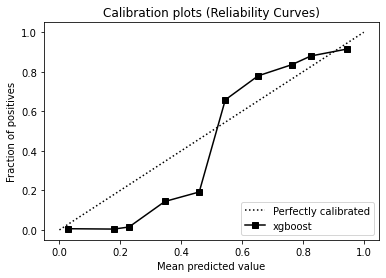

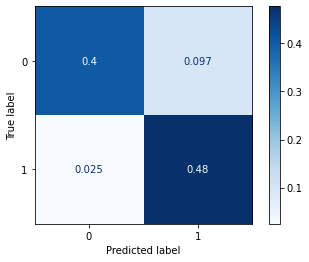

<Figure size 432x288 with 0 Axes>

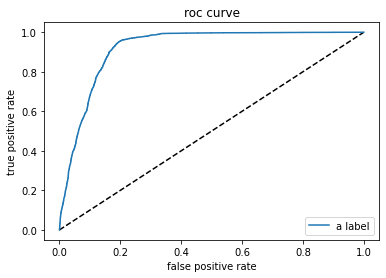

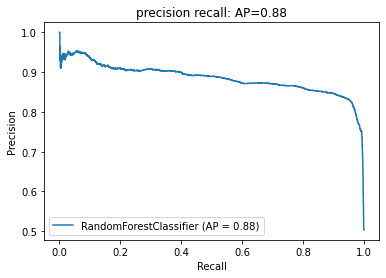

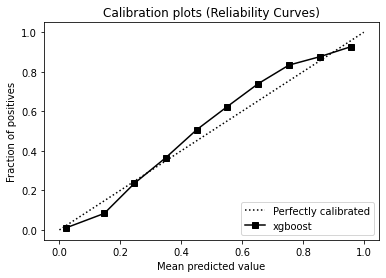

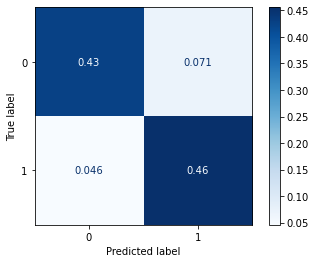

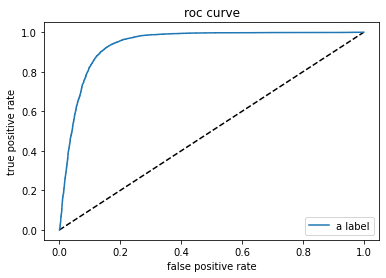

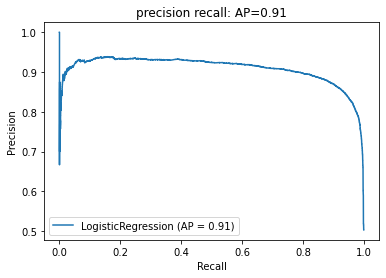

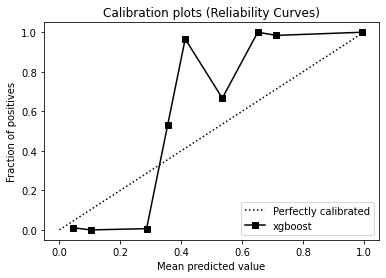

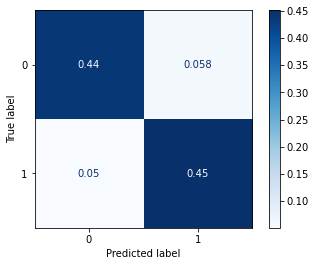

<Figure size 432x288 with 0 Axes>

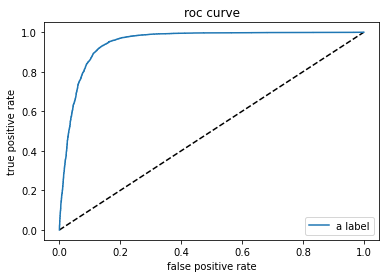

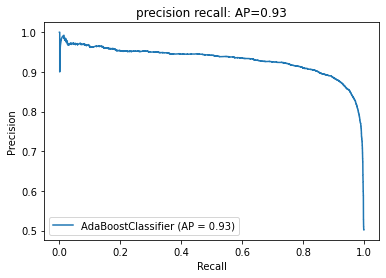

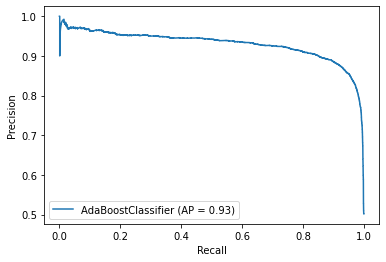

In [18]:
from mlrun import run_local, NewTask, mlconf

outputs = []
for model in models:
    task_copy = task_params.copy()
    task_copy.update(
        {"params":
         { "model_pkg_class" : model,
           "models_dest"     : f'sklearn/{model}'}})
    
    # customize specific model parameters
    if "RandomForestClassifier" in model:
        task_copy["params"].update({"CLASS_max_depth" : 2})

    if "LogisticRegression" in model:
        # use liblinear for small test set
        task_copy["params"].update({"CLASS_solver" : "liblinear"})
    
    if "AdaBoostClassifier" in model:
        # set max estimators below default, use weird learning rate
        task_copy["params"].update({"CLASS_n_estimators"  : 200,
                                    "CLASS_learning_rate" : 1})
    
    name = model.replace('.', '_')
    output = run_local(
        NewTask(**task_copy),
        handler=train_model,
        name=name,
        inputs={
            #"dataset"  : "https://raw.githubusercontent.com/yjb-ds/testdata/master/data/clf-k2-m24-n100k-bal.zip"
            "dataset"  : mlconf.artifact_path + f"/{dataset}"
        })
    outputs.append({name: output.outputs})

In [19]:
outputs

[{'sklearn_ensemble_RandomForestClassifier': {'test-accuracy': 0.8782857142857143,
   'test-error': 0.12171428571428572,
   'rocauc': 0.9192473184990909,
   'brier_score': 0.1544911441672054,
   'f1-score': 0.8868585998087751,
   'precision_score': 0.8309775034839737,
   'recall_score': 0.9507972665148063,
   'test_set': 'store://default/sklearn_ensemble_RandomForestClassifier_test_set#c3e2d89ddc0e4357b250eb652951e21f',
   'calibration curve': '/home/jovyan/data/plots/calibration curve.html',
   'confusion-matrix-normalized': '/home/jovyan/data/plots/confusion-matrix-normalized.html',
   'feature-importances': '/home/jovyan/data/plots/feature-importances.html',
   'roc-binary': '/home/jovyan/data/plots/roc-binary.html',
   'precision-recall-binary': '/home/jovyan/data/plots/precision-recall-binary.html',
   'feature-importances-tbl': '/home/jovyan/data/plots/precision-recall-binary.csv',
   'model': 'store://default/sklearn_ensemble_RandomForestClassifier_model#c3e2d89ddc0e4357b250eb65

### run remotely

In [22]:
from mlutils import create_function

fn_params = {
    "name"            : "sklearn_classifier",
    "project"         : "functions",
    "default_handler" : "train_model",
    "desc"            : "train any classifier using scikit-learn's API",
    "categories"      : ["ml", "training"],
    "labels"          : {"author": "yjb", "framework": "sklearn"},
    "kind"            : "job",
    "image"           : "yjbds/ml-models",
    "tag"             : mlconf.images_tag,
}

fn = create_function(fn_params, path='.')

[mlrun] 2020-05-25 22:18:20,822 function spec saved to path: ./function.yaml


In [23]:
outputs = []
for model in models:
    task_params.update(
        {"params":
         {"model_pkg_class":model, 
          "models_dest" : f'sklearn/{model}'}})

    name = model.replace('.', '_')
    fn.run(
        NewTask(**task_params),
        name=name,
        inputs={
            "dataset"  : mlconf.artifact_path + "/iris.parquet"
        })
    outputs.append({name: output.outputs})

[mlrun] 2020-05-25 22:18:30,081 starting run sklearn_ensemble_RandomForestClassifier uid=671872e0011a4f4aa977aeee567f544a  -> http://mlrun-api:8080
[mlrun] 2020-05-25 22:18:30,635 Job is running in the background, pod: sklearn-ensemble-randomforestclassifier-g7nzt
[mlrun] 2020-05-25 22:18:33,518 warning!, server (kubeflow) and client (default-tenant) namespace dont match
[mlrun] 2020-05-25 22:18:33,525 starting local run: main.py # train_model
Traceback (most recent call last):
  File "/opt/conda/bin/mlrun", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 764, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 717, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1137, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 956

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...7f544a,0,May 25 22:18:33,error,sklearn_ensemble_RandomForestClassifier,kind=jobowner=jovyan,dataset,model_pkg_class=sklearn.ensemble.RandomForestClassifiermodels_dest=sklearn/sklearn.ensemble.RandomForestClassifier,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run 671872e0011a4f4aa977aeee567f544a  , !mlrun logs 671872e0011a4f4aa977aeee567f544a 
[mlrun] 2020-05-25 22:18:36,747 run executed, status=error
runtime error: error, check logs


RunError: error, check logs

## tests

In [ ]:
from os import path

In [ ]:
df = pd.read_parquet(path.join(mlconf.artifact_path,'test_set.parquet'))
labels = df.pop('labels')

In [ ]:
adamodel = load(open(path.join(mlconf.artifact_path,'sklearn/sklearn.ensemble.AdaBoostClassifier/model.pkl'), 'rb'))
logregmodel = load(open(path.join(mlconf.artifact_path, 'sklearn/sklearn.linear_model.LogisticRegression/model.pkl'), 'rb'))
rfmodel = load(open(path.join(mlconf.artifact_path, 'sklearn/sklearn.ensemble.RandomForestClassifier/model.pkl'), 'rb'))

In [ ]:
print(adamodel)
print("errors\n", labels[labels!=np.argmax(adamodel.predict_proba(df), axis=1)], "\n")
print(logregmodel)
print("errors\n", labels[labels!=np.argmax(logregmodel.predict_proba(df), axis=1)], "\n")
print(rfmodel)
print("errors\n", labels[labels!=np.argmax(rfmodel.predict_proba(df), axis=1)], "\n")

In [ ]:
adamodel.feature_importances_

In [ ]:
dir(adamodel)

In [ ]:
logregmodel.solver

In [ ]:
dir(logregmodel)